In [1]:
import matplotlib_inline
import matplotlib.dates
from IPython.display import set_matplotlib_formats
import requests
import os
import re
import sqlite3
import pandas as pd
from IPython.display import display, HTML
import datetime
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

import json
from pathlib import Path

## configs
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams["figure.figsize"] = (15, 3)

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# plt.rcParams.keys()


## download config & data from server

In [19]:
##
## CONFIG
##
r = requests.get('https://dev.rasal.de/Heizungsmessung/store/config.json')
open('data/config.json', 'wb').write(r.content)

##
## DATA
##

r = requests.get(
    'https://dev.rasal.de/Heizungsmessung/store/assets/db.sqlite')
open('data/db.sqlite', 'wb').write(r.content)


# ## read local config.json and convert to list object
# with open('data/config.json', 'r') as f:
#   config = json.load(f)

# ## get some values
# databaseFile = config['db_file']
# ESPlist = config['ESP'].keys()




# # connect to database
# con = sqlite3.connect('data/db.sqlite')

# # make dataframe of database
# df_SQLite = pd.read_sql_query("SELECT * from haus_one", con)
# con.close()



# print(ESPlist) 
## print config object
# print(json.dumps(config, indent=4, sort_keys=True))

122880

## get config & data from local

In [39]:

##
## CONFIG
##
with open('data/config.json', 'r') as f:
  config = json.load(f)

## get some values
ESPlist = config['ESP'].keys()


##
## DATA
##
con = sqlite3.connect('data/db.sqlite')
# make dataframe of database
df_EG_1 = pd.read_sql_query("SELECT * from EG_1", con)
df_EG_2 = pd.read_sql_query("SELECT * from EG_2", con)
con.close()

# save as csv file
# df_EG_1.to_csv('data/df_EG_1.csv')
# df_EG_2.to_csv('data/df_EG_2.csv')

# print(df_EG_1.head())
# print(df_EG_2.head())


## TRY to create dfs dynamically...
# for esp in ESPlist:
#   print(f"df_{esp}")
#   name = f"df_{esp} = pd.read_sql_query(SELECT * from {esp}, {con})"
#   exec(name)
#   # name = pd.read_sql_query(f"SELECT * from {esp}", con)
# con.close()


## resample data

In [45]:
## get the data from the SQLIte dataframe
EG_1 = df_EG_1
## make datetime index
EG_1.index = pd.to_datetime(EG_1['date'])
## remove some columns
EG_1 = EG_1.drop('date', axis=1)
EG_1 = EG_1.drop('id', axis=1)
## print original data
# display(EG_1)
## upsample to 1 minute
EG_1 = EG_1.resample('1Min').mean()
# display(EG_1)
## interpolate values
EG_1 = EG_1.interpolate(method='linear')
# save as csv file
# EG_1.to_csv('data/EG_1_interpolated.csv')
# display(EG_1)

# get the data from the SQLIte dataframe
EG_2 = df_EG_2
# make datetime index
EG_2.index = pd.to_datetime(EG_2['date'])
# remove some columns
EG_2 = EG_2.drop('date', axis=1)
EG_2 = EG_2.drop('id', axis=1)
# print original data
# display(EG_2)
# upsample to 1 minute
EG_2 = EG_2.resample('1Min').mean()
# display(EG_2)
# interpolate values
EG_2 = EG_2.interpolate(method='linear')
# save as csv file
# EG_2.to_csv('data/EG_2_interpolated.csv')
# display(EG_2)


## plot

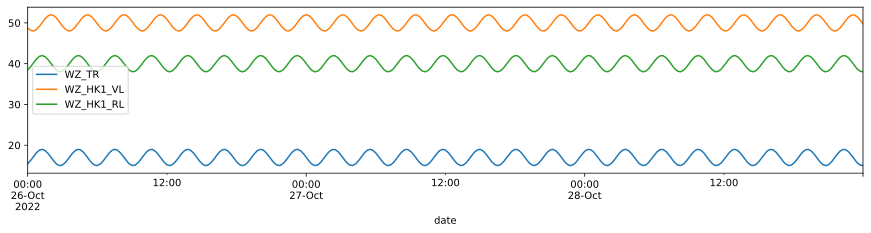

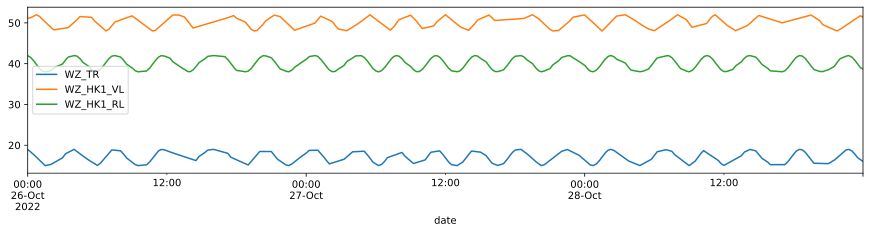

In [46]:

von = "2022-10-26"
bis = "2022-10-28"

ax = plt.gca()
EG_1[von:bis].plot(y='WZ_TR', kind='line', ax=ax)
EG_1[von:bis].plot(y='WZ_HK1_VL', kind='line', ax=ax)
EG_1[von:bis].plot(y='WZ_HK1_RL', kind='line', ax=ax)
plt.show()
 
ax = plt.gca()
EG_2[von:bis].plot(y='WZ_TR', kind='line', ax=ax)
EG_2[von:bis].plot(y='WZ_HK1_VL', kind='line', ax=ax)
EG_2[von:bis].plot(y='WZ_HK1_RL', kind='line', ax=ax)
plt.show()


In [47]:
## https://plotly.com/python/line-charts/
fig = go.Figure()
fig.add_trace(go.Scatter(x=EG_1.index,
              y=EG_1.WZ_HK1_VL, mode='lines', name='VL', line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=EG_1.index,
              y=EG_1.WZ_HK1_RL, mode='lines', name='RL',  line=dict(color='royalblue', width=2)))
 
fig.show()
